# Facial Emotion Recognition using AffectNet dataset with PyTorch

### Notebook 02

This notebook is to carry out the building of models for Facial Emotion recognition (FER) using the `AffectNet` dataset. Experiments to build the best model would be done here.


In [4]:
# Import libraries
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset, ConcatDataset
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from pathlib import Path
import os
import sys
import pickle
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import random
import numpy as np
import pandas as pd
from collections import Counter





In [5]:
# Get the absolute path to the project root (one level up from the notebook's directory)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add the project root to the Python path
sys.path.append(project_root)

In [6]:
# Import the custom modules
from scripts.data_etl import CustomDataset, DataETL
from utils.common import get_mean_std

<u>Work Plan</u>

1. Load the dataset using ETL
2. Build a baseline model and evaluate
3. Convert training and evaluation loop into a function
4. Experiment with different models - custom and transfer learning
5. Deploy the best model as a flask app for webcam enabled  real time recognition of emotions.

### 1. Load the dataset

In [7]:
proj_dir = Path('/Users/sho_mac/Library/CloudStorage/OneDrive-Personal/Documents/Personal Project Portfolio/Facial-Emotion-Recognition-using-AffectNet-Dataset-with-PyTorch')

In [8]:
# create path variable for data directory
data_dir = Path(proj_dir / 'data_new')
data_dir

PosixPath('/Users/sho_mac/Library/CloudStorage/OneDrive-Personal/Documents/Personal Project Portfolio/Facial-Emotion-Recognition-using-AffectNet-Dataset-with-PyTorch/data_new')

In [9]:
data_etl = DataETL(data_dir, 42, number_of_images=None, balanced_data=None)

In [10]:
dataset = CustomDataset(data_dir, transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]))

loader = DataLoader(dataset, batch_size=32, shuffle=True)

[2025-10-21 01:15:09,941: INFO: data_etl: Initializing custom data extraction...]
[2025-10-21 01:15:10,093: INFO: data_etl: Custom data extraction done.]


In [11]:
image, label = next(iter(loader))

In [12]:
image[2].shape

torch.Size([3, 224, 224])

In [13]:
# Load the dataset
data_etl = DataETL(data_dir, 42, 20000, False)

In [14]:
dataset = data_etl.extract_data(transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]))

[2025-10-21 01:15:23,652: INFO: data_etl: Extracting data......]
[2025-10-21 01:15:23,653: INFO: data_etl: Initializing custom data extraction...]
[2025-10-21 01:15:23,711: INFO: data_etl: Custom data extraction done.]
[2025-10-21 01:15:23,712: INFO: data_etl: Data extraction done......]


In [17]:

train_data, val_data, test_data = data_etl.transform_load(aug_class=['sad', 'disgust', 'contempt', 'fear', 'anger', 'neutral'])


[2025-10-21 01:16:22,471: INFO: data_etl: Transformation started......]
[2025-10-21 01:16:22,472: INFO: data_etl: Initializing custom data extraction...]
[2025-10-21 01:16:22,751: INFO: data_etl: Custom data extraction done.]
[2025-10-21 01:16:22,753: INFO: common: Mean & std calculations......]


[2025-10-21 01:17:33,526: INFO: data_etl: Extracting data......]
[2025-10-21 01:17:33,528: INFO: data_etl: Initializing custom data extraction...]
[2025-10-21 01:17:33,631: INFO: data_etl: Custom data extraction done.]
[2025-10-21 01:17:33,632: INFO: data_etl: Data extraction done......]
[2025-10-21 01:17:33,632: INFO: data_etl: Splitting data started.......]
[2025-10-21 01:17:33,640: INFO: data_etl: Splitting data completed.......]
[2025-10-21 01:17:33,640: INFO: data_etl: Applying data augmentation to training data......]


Augmenting classes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:26<00:00,  4.46s/it]


[2025-10-21 01:21:24,656: INFO: data_etl: Train data count: 19545]
[2025-10-21 01:21:24,681: INFO: data_etl: Validation data count: 2000]
[2025-10-21 01:21:24,682: INFO: data_etl: Test data count: 2000]
[2025-10-21 01:21:24,684: INFO: data_etl: Transformation completed]


In [28]:
type(train_data)

torch.utils.data.dataset.TensorDataset

In [31]:
batch_size = 32

In [32]:
# Create the dataloaders
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=2)
val_dataloader = DataLoader(val_data, shuffle=False, batch_size=batch_size, num_workers=2)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=batch_size, num_workers=2)

In [33]:
sample_images, sample_labels = next(iter(train_dataloader))

In [34]:
# Check the shape of a sample random image
sample_images[0].shape

torch.Size([3, 224, 224])

# Check class balance

In [35]:
sample_features, sample_label = train_data[0]

In [36]:
sample_label

tensor(5)

In [38]:
idx_to_class = {0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise'}


In [39]:
idx_to_class

{0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise'}

In [40]:
class_counts = Counter([idx_to_class[label.item()] for batch in tqdm(train_dataloader) for label in batch[1]])
print("Class distribution:", class_counts)



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 611/611 [00:05<00:00, 102.59it/s]

Class distribution: Counter({'fear': 2469, 'neutral': 2469, 'surprise': 2469, 'anger': 2469, 'contempt': 2469, 'disgust': 2469, 'sad': 2469, 'happy': 2262})


In [41]:
class_counts


Counter({'fear': 2469,
         'neutral': 2469,
         'surprise': 2469,
         'anger': 2469,
         'contempt': 2469,
         'disgust': 2469,
         'sad': 2469,
         'happy': 2262})

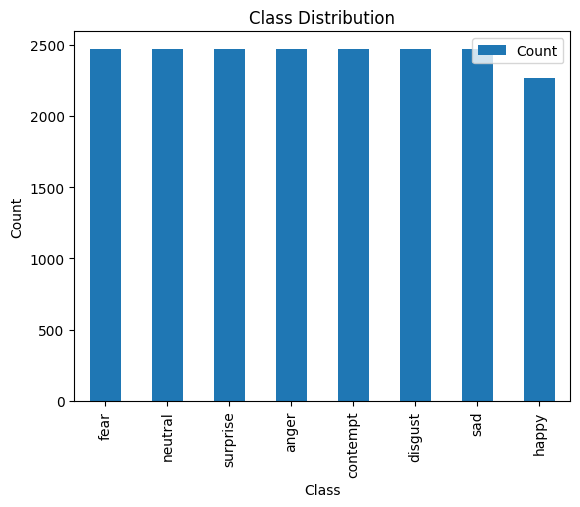

In [42]:
df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
df.plot(kind='bar', title='Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [44]:
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using mps device.
